# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist
import cv2

In [2]:
def get_depth(frame):
    encoder, decoder,loaded_dict_enc = loadDepthModel();
    frame_width = frame.shape[0]
    frame_height = frame.shape[1]
    feed_height = loaded_dict_enc['height']
    feed_width = loaded_dict_enc['width']
    img_input = getImageInput(frame,feed_height,feed_width);
    
    with torch.no_grad():
        features = encoder(img_input)
        outputs = decoder(features)

    disp = outputs[("disp", 0)]
    
    disp_resized = torch.nn.functional.interpolate(disp,
    (frame_width, frame_height), mode="bilinear", align_corners=False)

    # Saving colormapped depth image
    disp_resized_np = disp_resized.squeeze().cpu().numpy()
    
    return disp_resized_np
    

In [3]:
def getImageInput(frame,feed_height,feed_width):
    img=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    img_pil=pil.fromarray(img)
    original_width, original_height = img_pil.size

    input_image_resized = img_pil.resize((feed_width, feed_height), pil.LANCZOS)

    input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)
    return input_image_pytorch

## Setting up network and loading weights

In [4]:
def loadDepthModel():
    model_name = "mono_640x192"

    download_model_if_doesnt_exist(model_name)
    encoder_path = os.path.join("models", model_name, "encoder.pth")
    depth_decoder_path = os.path.join("models", model_name, "depth.pth")

    # LOADING PRETRAINED MODEL
    encoder = networks.ResnetEncoder(18, False)
    depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

    loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
    filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
    encoder.load_state_dict(filtered_dict_enc)

    loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
    depth_decoder.load_state_dict(loaded_dict)

    encoder.eval()
    depth_decoder.eval();
    return encoder,depth_decoder,loaded_dict_enc

## Loading the test image and preprocessing

In [30]:
image_path = "myFrame.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [32]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

## Plotting

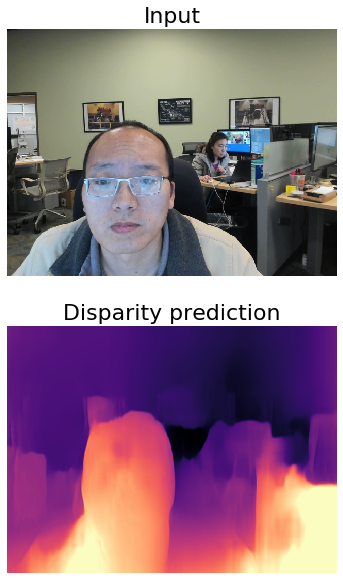

In [33]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

In [27]:
disp_resized_np.shape

(235, 638)

In [1]:
import cv2

In [5]:
vc = cv2.VideoCapture(0)

In [6]:
cv2.namedWindow("preview")
cv2.namedWindow("depth")


if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

while rval:
    frame=cv2.flip(frame,1)
    cv2.imshow("preview", frame)
    depth=get_depth(frame)
    cv2.imshow("depth",depth)
    rval, frame = vc.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break
cv2.destroyWindow("preview")
cv2.destroyWindow("depth")

In [9]:
test_img= torch.from_numpy(frame).float().unsqueeze(0)

In [37]:
test_img=cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

In [38]:
test_img.shape

(480, 640, 3)

In [39]:
im_pil=pil.fromarray(test_img)

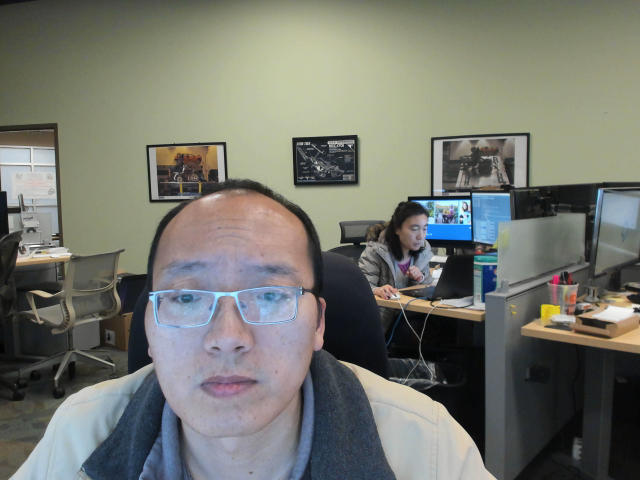

In [40]:
im_pil